In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import os

import pickle
import numpy as np
import pandas as pd

In [2]:
#this will set the num of lines to use as a corpus.. limited by the memory and processing power.
#this lines need to be run.
# if the value of numlines is changed when creating a new model, it should changed here. 
# Once a model is created with the num lines, it should not be changed.
numlines=10000

In [3]:
# import os
# from tensorflow.keras.models import load_model
# import pickle
# import pandas as pd

if os.path.exists("nextword_lstm_model.h5"):
    print("File exists!")
    model = load_model("nextword_lstm_model.h5")

    # 2. Load the tokenizer

    with open("tokenizer.pkl", "rb") as f:
        tokenizer = pickle.load(f)
    df = pd.read_parquet("train-00000-of-00010.parquet", engine="pyarrow")
    corpus = df["text"].dropna().tolist()[:numlines]

# Prepare training data (same as during original training)
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

    max_seq_len = max([len(x) for x in input_sequences])
    input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='pre')
        
else:
    print("File does not exist.")
    print ("You need to train the model first, before proceeding to test the next word prediction.")

File exists!


The below code is for continue training the model is there is a trained model to be found.
The default epoch is 1, user can change to make it deem fit to run the model.
If you do not have a trained model, you should proceed to cell


In [ ]:
    # 1. Load the trained model

# from tensorflow.keras.models import load_model
model = load_model("nextword_lstm_model.h5")

    # 2. Load the tokenizer
# import pickle
with open("tokenizer.pkl", "rb") as f:
        tokenizer = pickle.load(f)

total_words = len(tokenizer.word_index) + 1

# Load the data again (you need this for continued training)
import pandas as pd
df = pd.read_parquet("train-00000-of-00010.parquet", engine="pyarrow")
corpus = df["text"].dropna().tolist()[:numlines]

# Prepare training data (same as during original training)
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_seq_len = max([len(x) for x in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='pre')

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Prepare X and y for training
X = input_sequences[:, :-1]
y = input_sequences[:, -1]
y = tf.keras.utils.to_categorical(y, num_classes=total_words)

# Continue training the loaded model
print("Continuing training...")


# Train the model (use validation_split to monitor overfitting)
# adjust the epoch to run it as deem fit.. default set to one.
history = model.fit(X, y, epochs=1, batch_size=64, validation_split=0.1, verbose=1)
# Save the updated model
model.save("nextword_lstm_model.h5")

# import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

Continuing training...
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 136s 91ms/step - accuracy: 0.4796 - loss: 2.1908 - val_accuracy: 0.1084 - val_loss: 10.1712


If no model file exist, you need to create a model first.
If a trained model exit, the below cell should be skipped

In [5]:
####Attention! This cell can be skipped if you are using a pre-trained model #####
# Replace with your actual file path

df = pd.read_parquet("train-00000-of-00010.parquet", engine="pyarrow")

# Preview the data
print(df.head())

print(f"Total rows: {len(df)}")
# Check memory usage
print(df.info(memory_usage="deep"))

corpus = df["text"].dropna().tolist()[:numlines]


tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_seq_len = max([len(x) for x in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='pre')

# previous model definition
# model = Sequential()
# model.add(Embedding(total_words, 10, input_length=max_seq_len-1))
# model.add(LSTM(100))
# model.add(Dense(total_words, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.fit(X, y, epochs=30, verbose=1)

# Define improved model architecture
model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_seq_len-1))  # Larger embedding size
model.add(LSTM(128, return_sequences=True))                        # First LSTM layer
model.add(Dropout(0.3))                                            # Dropout for regularization
model.add(LSTM(64))                                                # Second LSTM layer
model.add(Dense(total_words, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Prepare X and y for training
X = input_sequences[:, :-1]
y = input_sequences[:, -1]
y = tf.keras.utils.to_categorical(y, num_classes=total_words)

# Train the model (use validation_split to monitor overfitting)
history = model.fit(X, y, epochs=1, batch_size=64, validation_split=0.1, verbose=1)

# 1. Save the trained model
model.save("nextword_lstm_model.h5")

# 2. Save the tokenizer using pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

                                                text
0  usually , he would be tearing around the livin...
1  but just one look at a minion sent him practic...
2  that had been megan 's plan when she got him d...
3  he 'd seen the movie almost by mistake , consi...
4  she liked to think being surrounded by adults ...
Total rows: 7400423
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7400423 entries, 0 to 7400422
Data columns (total 1 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   text    object
dtypes: object(1)
memory usage: 770.0 MB
None


c:\NYP\dev\dev\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1467/1467 ━━━━━━━━━━━━━━━━━━━━ 130s 87ms/step - accuracy: 0.0409 - loss: 6.3270 - val_accuracy: 0.0428 - val_loss: 6.0769


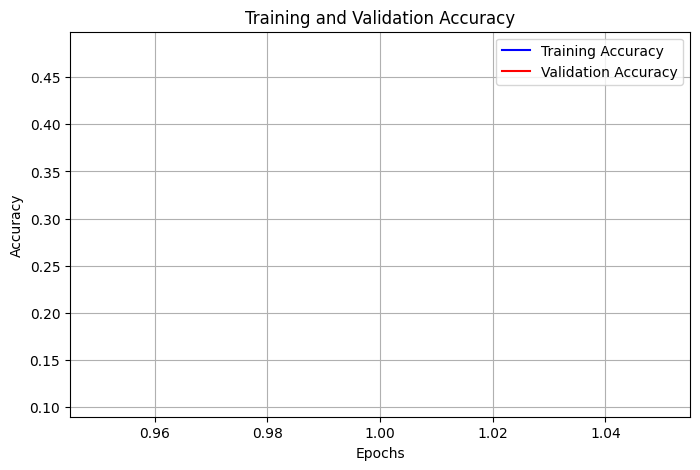

In [ ]:
# Plot training and validation accuracy only if you have trained the model at least onca few times
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history.get('val_accuracy')
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
if val_acc is not None:
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
def predict_next_word(seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted)
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            return word
    return ""

In [8]:
# Example usage of the predict_next_word function
seed_list =[]

seed_list = [
    "I am moving to the",
    "places I love to",
    "Tom is too",
    "Tom is too smart to be",
    "fruits I like to",
    "I love playing with my",
    "Music to my",
    "Heed a good",
    "My dog wags its",
    "Too much of a",
    "just one look",
    "What is the",
    "it been a long",
    "He act very humble and",
    "You are a beautiful",
    "Moses is very",
    "This is a treasure",
    "kindly help",
    "breakfast is being",
    "Dog is a",
    "A human",
    "A lion roars",
    "AI is a unique"
   
]

for seed in seed_list:
    next_word = predict_next_word(seed)
    print(f"{seed} → {next_word}")



I am moving to the → sixth
places I love to → make
Tom is too → much
Tom is too smart to be → fine
fruits I like to → get
I love playing with my → wife
Music to my → old
Heed a good → spanking
My dog wags its → love
Too much of a → ultrasound
just one look → out
What is the → first
it been a long → time
He act very humble and → waited
You are a beautiful → game
Moses is very → way
This is a treasure → vulnerability
kindly help → her
breakfast is being → the
Dog is a → good
A human → look
A lion roars → man
AI is a unique → thing


In [15]:
#single testing or testing against ngram 
seed ="open"
next_word = predict_next_word(seed)
print(f"{seed} → {next_word}")

open → it


To check how the model will form the complete sentence. Double single quotes the model predicted an empty string but it seems it can still continue with the predictions or hulucinating base on the context of words but it may or may not make sense. LOL

In [10]:
def generate_sequence(seed_text, max_words=20):
    result = seed_text
    for _ in range(max_words):
        next_word = predict_next_word(result)
        if not next_word or next_word in result.split():
            break  # Stop if no word is predicted or word repeats (to avoid infinite loops)
        result += ' ' + next_word
    return result


# Example usage:
for seed in seed_list:
    generated = generate_sequence(seed, max_words=20)
    print(generated)

I am moving to the sixth floor and down through
places I love to make you feel that way '' she said softly as
Tom is too much today '' he said with a smile whenever she was going to be true on the same table
Tom is too smart to be fine '' he replied with a grin on his chest i was n't feeling
fruits I like to get you
I love playing with my wife '' pesh said as she continued through over her face causing
Music to my old life '' he remarked with empathy the judge hit him over and out of
Heed a good spanking her
My dog wags its love i can do '' she said with a grimace
Too much of a ultrasound '' she said with
just one look out of the world you ca n't imagine dinner '' he argued as
What is the first time with her unborn few minutes '' she replied
it been a long time since she 'd driven my son ''
He act very humble and waited for her 's family
You are a beautiful game '' she said with
Moses is very way to start thins off the kitchen out of
This is a treasure vulnerability to you '' she said 

In [25]:
import random

# 1️⃣ Get all unique words from the corpus
all_tokens = []
for line in corpus:
    all_tokens.extend(str(line).lower().split())
unique_words = list(set(all_tokens))

# 2️⃣ Randomly sample 50 words
sample_size = min(50, len(unique_words))
random_50_words = random.sample(unique_words, sample_size)
print("Random 50 words:", random_50_words)

# 3️⃣ Evaluate Top-1 accuracy for next word prediction, with detailed printout
correct = 0
total = 0

print("\n--- Next Word Prediction Evaluation from Corpus (LSTM Model) ---")
for word in random_50_words:
    for line in corpus:
        tokens = str(line).lower().split()
        if word in tokens:
            idx = tokens.index(word)
            if idx < len(tokens) - 1:
                true_next = tokens[idx + 1]
                predicted = predict_next_word(' '.join(tokens[:idx+1]))
                total += 1
                print(f"\nInput: '{' '.join(tokens[:idx+1])}'")
                print(f"Actual Next Word: '{true_next}'")
                print(f"Model Prediction: '{predicted}'")
                if predicted == true_next:
                    correct += 1
                    print("Status: CORRECT")
                else:
                    print("Status: INCORRECT")
                break  # Only test the first occurrence

accuracy = correct / total if total > 0 else 0
print(f"\n--- Prediction Summary ---")
print(f"Total predictions made: {total}")
print(f"Correct (Top 1 Prediction): {correct} / {total} ({accuracy:.2%})")
print("\n--- End of Evaluation ---")

Random 50 words: ['past', 'ribs', 'unkempt', 'instructed', 'marketing', 'worry', 'closing', 'brazen', 'abruptly', 'meet', 'finance', 'understand', 'authorized', 'unbeknownst', 'eighteen', 'announced', 'usually', 'forever', 'flowed', 'discussed', 'overused', 'thrummed', 'lounged', 'trace', 'overpower', 'nose', 'glittering', 'engagement', 'told', 'defeat', 'facetime', 'comfortable', 'boundaries', 'racy', 'buzzing', 'dare', 'fluttered', 'cartoon', 'non-stop', 'flattered', 'cool', 'no', 'super', 'lowest', 'expectant', 'elizabeth', 'following', 'beast', 'sticking', 'buttons']

--- Next Word Prediction Evaluation from Corpus (LSTM Model) ---

Input: 'i mean , whatever was between us is all in the past'
Actual Next Word: '.'
Model Prediction: 'and'
Status: INCORRECT

Input: 'she shoved herself so hard away from the person that she ended up elbowing him in the ribs'
Actual Next Word: '.'
Model Prediction: 'n'
Status: INCORRECT

Input: 'she ruffled his still unkempt'
Actual Next Word: 'bed'
Mod